## This code creates control functionals and compare the error in estimating E_f(h(X)) using them with a classical Monte Carlo method

## Sources used to create this code: 

"Control Functional for Monte Carlo Integration" by Oates and al, 2016

https://scipython.com/blog/visualizing-the-bivariate-gaussian-distribution/

http://jakevdp.github.io/mpl_tutorial/tutorial_pages/tut5.html

In [10]:
# scientific computing library
import numpy as np
# visualization tools
import matplotlib.pyplot as plt
from sympy import symbols, diff
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from basekernel import *#import some base kernels k
from scipy.stats import multivariate_normal

## Definition of the kernel k_0 ( notation similar as in "Control Functional for Monte Carlo Integration" by Oates and al, 2016)

In [11]:
#u_2d(x) returns a 2d-array of size (dim parameter \times 1); it is defined at page 6 of the paper
#Control Functional for Monte Carlo Integration" by Oates and al
# x is a 1d-array of size [... \times dim parameter], cov is a 2d-array, mean is a 1d-array
#This function only works for multivariate normal distribution
def u_2d(x):
    x=np.atleast_2d(x).T
    return(-np.linalg.solve(cov, x-np.atleast_2d(mean).T))

#particular case of univariate normal distribution
#def u(x):
#    return(-x)

#k0 is defined by the formula given in theorem 1 of the paper 
#"Control Functional for Monte Carlo Integration" by Oates and al, page 7
def k0(x, y):# x, y are 1d arrays
    out = np.trace(kernel.gradxgrady(x,y))#scalar
    out += np.dot(u_2d(x).T,kernel.grady(x,y))[0]
    out += np.dot(u_2d(y).T,kernel.gradx(x,y))[0]
    out += kernel(x,y)*np.dot(u_2d(x).T,u_2d(y))[0, 0]
    return(out)#the outuput is a scalar

## Definition of E_f[h(X)] (a.k.a mu_hat in the article "Control Functional for Monte Carlo Integration" by Oates and al, 2016)

In [12]:
###K0, K10, f0, f1, f1_hat and mu_hat are defined in the Lemma 3 of the paper 
  #"Control Functional for Monte Carlo Integration" by Oates and al
  #In all these functions, "samples" are  (n x dim of parameter) 2d-arrays


#K0 returns a 2d-array of size [m \times m] such that [K0]_{ij}=k2(samples[i], samples[j]) and where m<n
def K0(m, samples):
    K0=np.zeros((m, m))
    for i in range(m):
        K0[i, i]= k0(samples[i], samples[i])
        for j in range (i):
            K0[i, j]= k0(samples[i], samples[j])
            K0[j, i]= k0(samples[i], samples[j])
    return(K0)

#returns a 2d-array of size [(n-m) \times m] such that [K0]_{ij}=k2(samples[i], samples[j]) and where m<n
def K10(m, samples):
    K10=np.zeros((len(samples)-m, m))
    for i in range(len(samples)-m):
        for j in range (m):
            K10[i, j]= k0(samples[i+m], samples[j])
    return(K10)   

# f0 return a 2d-array of size [m \times 1]
def f0(f, m, samples):#f is a function and m a scalar
    return(f(samples[:m]))

#f1 return a 2d-array of size [(len(samples)-m) \times 1]   
def f1(f, m, samples):#f is a function and m a scalar
    return f(samples[m:len(samples)])

#f1_hat returns a 2d-array of size [(len(samples)-m) \times 1]   
def f1_hat(f, m, samples):
    lamb = 10**(-10)
    A = (1-K10(m, samples).dot(np.linalg.solve(K0(m, samples)+lamb*m*np.identity(m),  np.atleast_2d(np.ones(m)).T)))#2d array
    B = np.atleast_2d(np.ones(m)).dot(np.linalg.solve(K0(m, samples)+lamb*m*np.identity(m), f0(f, m, samples)))#2d array
    B = B/(1+np.atleast_2d(np.ones(m)).dot(np.linalg.solve(K0(m, samples)+lamb*m*np.identity(m), np.atleast_2d(np.ones(m)).T)))#B is a 2d array
    out = K10(m, samples).dot(np.linalg.solve(K0(m, samples)+lamb*m*np.identity(m), f0(f, m, samples)))
    out += A.dot(B)
    return out

#mu_hat returns a [1 \times 1] 2d-array
def mu_hat(f, m, samples):
    lamb = 10**(-10)
    B = np.atleast_2d(np.ones(m)).dot(np.linalg.solve(K0(m, samples)+lamb*m*np.identity(m), f0(f, m, samples)))#2d array
    B = B/(1+np.atleast_2d(np.ones(m)).dot(np.linalg.solve(K0(m, samples)+lamb*m*np.identity(m), np.atleast_2d(np.ones(m)).T)))#B is a 2d array
    return(1/(len(samples)-m)*np.atleast_2d(np.ones(len(samples)-m)).dot(f1(f, m, samples)-f1_hat(f, m, samples))+B)


## Definiton of the control variates

In [13]:
#f1_hat2 returns a (dim grid \times 1) 2d-array, which values are the image of xgrid by the control variate function
#in the case of a one-dimensional space \mathcal{X}
def f1_hat2(xgrid, f, m, samples):#xgrid is 1d array and samples is a 2d array
    lamb = 10**(-10)
    k_xgrid_samples = np.zeros((len(xgrid), m))
    for i in range(len(xgrid)):
        for j in range (m):
            k_xgrid_samples[i, j]= k0(np.atleast_1d(xgrid[i]), samples[j])
    return k_xgrid_samples.dot(np.linalg.solve(K0(m, samples)+lamb*m*np.identity(m), f0(f, m, samples)))

#f1_hat2 returns a (dim grid \times 1) 2d-array, which values are the image of [xgrid \times xgrid] by the control variate
#in the case of a two-dimensional space \mathcal{X}
def f1_hat2_dim2(xgrid, f, m, samples):#xgrid is 1d array and samples is a 2d array
    lamb = 10**(-10)
    X, Y = np.meshgrid(xgrid, xgrid)
    k_xgrid_samples = np.zeros((len(X), m))
    for i in range(len(X)):
        for j in range (m):
            k_xgrid_samples[i, j]= k0(np.atleast_1d(np.concatenate(X[i],Y[i])), samples[j])
    return k_xgrid_samples.dot(np.linalg.solve(K0(m, samples)+lamb*m*np.identity(m), f0(f, m, samples)))

## Plot the function h, the distribution against which we integrate and the control variate

In [33]:
#Case of a one dimensional random variable X
#plot the function we want to integrate with respect to a density, the control variate and the distribution
def plot_functions_1D(f, samples):#samples is an [n \times 1] array.
    # x-axis variable
    x = np.linspace(-3.5, 3.5)
    # y-axis variable
    y_f = x #This line needs to be adapted according to the function h we choose
    y_newf = f1_hat2(x, f, 70, samples)
    y_distri=(1/(np.sqrt(2 * np.pi)) *np.exp( - x**2 / 2 ))
    # visualize
    axes = plt.gca()
    axes.set_ylim([-1.5,1.5])
    plt.plot(x, y_f, label="h")
    plt.plot(x, y_newf, label="Control variate")
    plt.plot(x, y_distri, label="pdf", linestyle="-.")
    plt.title("Plot for h(x)=x")
    plt.legend();
    return(plt.show())
 
    #source: https://scipython.com/blog/visualizing-the-bivariate-gaussian-distribution/
    # and http://jakevdp.github.io/mpl_tutorial/tutorial_pages/tut5.html
#Case of a two dimensional random variable X
#plot the function we want to integrate with respect to a density and the distribution
def plot_functions_2D(samples):#samples is a [n \times 2] array.
    #plot the function f
    x = np.outer(np.linspace(-3, 3, 50), np.ones(50))
    y = x.copy().T
    z = (x+y)#This line needs to be adapted according to the function h we choose
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(x, y, z, rstride=3, cstride=3, linewidth=1, antialiased=True, alpha=0.3)
    #plot the distribution with an offset
    rv = multivariate_normal(mean, cov)
    X, Y = np.meshgrid(x, y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    Z= rv.pdf(pos)
    cset = ax.contourf(X, Y, Z, zdir='z', offset=-4, cmap=cm.viridis)
    # Adjust the limits 
    ax.view_init(27, -21)
    ax.set_zlim(-4,8)
    ax.text2D(0.8, 0.6, "h", transform=ax.transAxes)
    ax.text2D(0.16, 0.35, "pdf", transform=ax.transAxes)
    return(plt.show())

## Functions to plot the (expectation of ) the Error or logError

In [15]:
#plot the error assessing E_f[X] by classic Monte Carlo method and with control variates when n=30 and n=50    
def visu_1D(f, true_mean):
    # x-axis variable
    x1 = np.arange(start=1, stop=101, step=10) 
    x2 = np.arange(start=31, stop=101, step=10)
    x3 = np.arange(start=51, stop=101, step=10)
    # y-axis variable
    y1= np.zeros(len(x1))
    y2= np.zeros(len(x2))
    y3= np.zeros(len(x3))
    np.random.seed(123)
    samples = np.random.multivariate_normal(mean, cov, 100)
    for j in range(0, len(x1)):
        y1[j] = np.log10(abs(np.sum(f(samples[:x1[j]]))/x1[j]-true_mean)) 
    for j in range(0, len(x2)):      
        y2[j] = np.log10(abs(mu_hat(f, 30, samples[:x2[j]]).item()-true_mean))
    for j in range(0, len(x3)): 
        y3[j] = np.log10(abs(mu_hat(f, 50, samples[:x3[j]]).item()-true_mean))        
    # visualize
    plt.plot(x1, y1, label= "Classic Monte Carlo method", linestyle="-",  marker="o",linewidth=1)
    plt.plot(x2, y2, label= "n="+ str(30), linestyle="-",  marker="o",linewidth=1)
    plt.plot(x3, y3, label= "n="+ str(50), linestyle="-",  marker="o",linewidth=1) 
    plt.xticks(x1)
    plt.title("Plot for h(x)=x")
    plt.xlabel("m= Total number of samples used")
    plt.ylabel("log|Error|")
    plt.legend();
    return(plt.show())
 
#Plots of the expectation of the error against the number of Monte Carlo samples’  
#   N number of replicates   
def visu_expectation(f, true_mean, N):
    x1 = np.arange(start=1, stop=101, step=10) 
    x2 = np.arange(start=31, stop=101, step=10)
    x3 = np.arange(start=51, stop=101, step=10)  
    y1=np.zeros((N, len(x1)))
    y2=np.zeros((N, len(x2)))
    y3=np.zeros((N, len(x3)))
    for i in range(N):
        samples = np.random.multivariate_normal(mean, cov, 100)
        # y-axis variable
        for j in range (0, len(x1)):
            y1[i, j] = np.log10(abs(np.sum(f(samples[:x1[j]]))/x1[j]-true_mean)) 
        for j in range(0, len(x2)):      
            y2[i, j] = np.log10(abs(mu_hat(f, 30, samples[:x2[j]]).item()-true_mean))
        for j in range(0, len(x3)): 
            y3[i, j] = np.log10(abs(mu_hat(f, 50, samples[:x3[j]]).item()-true_mean))  
        # making sure that the length of the two variables match
        # visualize
    plt.plot(x1, 1/N*np.sum(y1, axis=0),label= "Classic Monte Carlo method", linestyle="-",  marker="o",linewidth=1)
    plt.plot(x2, 1/N*np.sum(y2, axis=0), label= "n="+ str(30), linestyle="-",  marker="o",linewidth=1)
    plt.plot(x3, 1/N*np.sum(y3, axis=0), label= "n="+ str(50), linestyle="-",  marker="o",linewidth=1) 
    plt.title("Plot for h(x)=x")
    plt.xlabel("m=Number of Monte Carlo Samples")
    plt.ylabel("Elog|Error|")
    plt.legend();
    return(plt.show())   

## Functions we want to integrate with respect to the probability density f  

In [16]:
#h1 returns a [len(x) \times 1] 2d-array such that h1(x)=\sum_{i=1}^{n} x_i
def h1(x):#x is a 2d-array
    return(x.dot(np.ones((len(x[0]), 1))))

#sphere function  returns a [len(x) x 1] 2d-array such; h2(x)=\sum_{i=1}^{d} x_i^2 where d is the dimension of the integration space
def h2(x):#x is a 2d-array
    return (x**2).dot(np.ones((len(x[0]), 1)))

#h3 returns a [len(x) x 1] 2d-array such that h3(x)=\sum_{i=1}^{n} x_i^3
def h3(x):#x is a 2d-array
    return (x**3).dot(np.ones((len(x[0]), 1)))

## Example in the case of a one-dimensional space \mathcal{X}

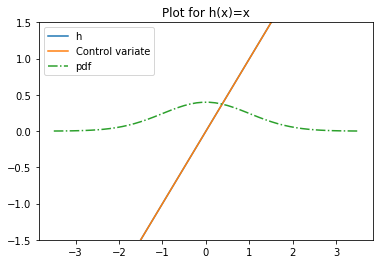

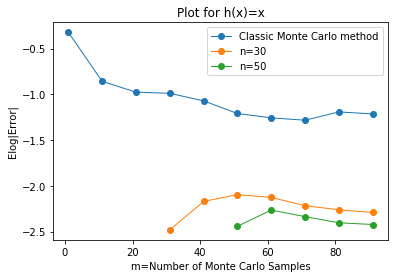

In [35]:
#Choice of the base kernel k
kernel = KernelMatern12(5)
#Choice of the mean of the multivariate normal distribution
mean = np.array([0])#1d-array
#Choice of the variance of the multivariate normal distribution
cov = np.array([[1]])#2d-array

np.random.seed(123)
samples1 = np.random.multivariate_normal(mean, cov, 100)
plot_functions_1D(h1, samples1)
visu_expectation(h1, 0, 50)

## Example in the case of a two-dimensional space \mathcal{X}

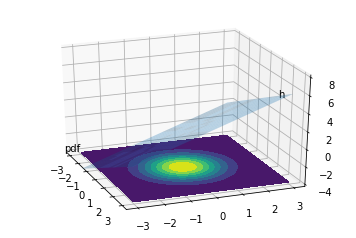

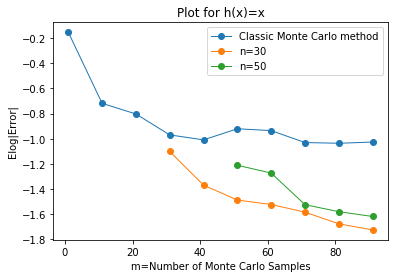

In [36]:
#Choice of the base kernel k
kernel = KernelMatern12(5)
#Choice of the mean of the multivariate normal distribution
mean = np.array([0, 0])
#Choice of the variance of the multivariate normal distribution
cov = np.array([[1, 0], [0, 1]] )

np.random.seed(123)
samples2 = np.random.multivariate_normal(mean, cov, 100)
plot_functions_2D(samples2)
visu_expectation(h1, 0, 50)